<img src="ETH-Zurich-Logo.png" style="width: 400px; padding-left: 50px; padding-top: 20px;" align="right"/>


# Project 7- High-Performance Computing in Jupyter

## Student Name, Date

# Example of a simple NLP problem solved with IPOPT

Minimize $ f(x) := \left( x_0 \cdot x_3  \cdot \sum_{i=0}^2 x_i \right) + x_2$

subject to 

$\qquad x^T x = 40$

$\qquad \prod_{i=0}^3 x_i \geq 25$

$\qquad 1 \leq x \leq 5$

In [1]:
import os
# os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
os.environ['OMP_NUM_THREADS']

'1'

In [3]:
from __future__ import print_function, unicode_literals

import sys, time
import ipopt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

#import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

We need to implement a Python object that evaluates:
* Objective function $f(x)$ 
* Objective function gradient $\nabla_x f(x)$
* Constraints $g(x)$
* Jacobian of constraints $\nabla_x g(x)$
* Hessian of Lagrangian $\nabla^2_x \sigma f(x) + \lambda^T \nabla^2_x g(x)$

In [4]:
class PdeProblem(object):
    def __init__(self, n, debug = True, plot_freq = 1):
        self.debug = debug
        self.plot_freq = plot_freq
        
        # grid cell size
        self.h = 1 / (n+2 -1)
        self.h2 = self.h**2

        # -- Setup dimensions
        # y = n+2 x n+2 matrix, incl corners
        # u = 4n vector of the boundary, excl corners
        #    -> x = (n+2)^2 + 4n = complete state
        # Note: state x is flattened, variables like y, yd are 2d (if possible)
        
        # Flattened lengths
        ylen = (n+2)**2
        ulen = 4*n
        xlen = ylen + ulen
        
        self.n = n # inner grid dimension
        self.N = self.num_states = xlen # number of variables
        self.M = self.num_constraints = ylen # number of constraints, we have one constraint per domain cell
        
        
        # -- Bounds for objective and constraints
        y_lb = np.full(ylen, float('-inf')) # unbounded?
        y_ub = np.full((n+2, n+2), 3.5)
        u_lb = np.zeros(ulen)
        u_ub = np.full(ulen, 10)
        
        self.lb = np.concatenate((y_lb.flatten(), u_lb))
        self.ub = np.concatenate((y_ub.flatten(), u_ub))

        # Constraints
        self.cl = np.full(self.M, 0) #float('-inf'))
        self.cu = np.full(self.M, 0)
        
        
        # -- Setup const vars for objective function
        def eval_yd(i, j):                          
            x1 = i * self.h
            x2 = j * self.h
            return 3 + 5 * x1 * (x1 - 1) * x2 * (x2 -1)
        
        self.yd = np.fromfunction(eval_yd, (n +2, n +2))
        self.ud = np.zeros(ulen)
        self.alpha = 0.01
        
        
        # -- Initial conditions
        def eval_y0(i, j):                          
            x1 = i * self.h
            x2 = j * self.h
            # This formula satisfies all constraints. It does not have to, but it is usually faster.
            return 5 * x1 * (x1 - 1) * x2 * (x2 -1) +1
        
        y0 = np.fromfunction(eval_y0, (n +2, n +2))
#         y0 = np.full(ylen, 1)
#         y0 = np.zeros(ylen)
        u0 = np.concatenate((y0[0, 1:-1], y0[1:-1, 0], y0[-1, 1:-1], y0[1:-1, -1]))
        self.x0 = np.concatenate((y0.flatten(), u0))
        self.y0 = y0
        
        self.ylen = ylen
        self.ulen = ulen
        self.xlen = xlen
        assert xlen == len(self.x0)
        
        self.setup_plot()
    
    
    def decompose_x(self, x):
        """returns (y,u) tuple from the concatenated state vector x
        y is unflattened (i.e. 2D)"""
        assert len(x) == self.xlen
        
        n = self.n
        y = np.reshape(x[:self.ylen], (n+2, n+2))
        u = x[self.ylen:]
        
        assert len(u) == self.ulen
        
        return y, u
    
    
    def objective(self, x):
        """The callback for calculating the objective, F^h(y, u)  (19)"""
#         print('objective')
        self.x = x # for plotting only
        
        y, u = self.decompose_x(x)
        
        y_part = self.h2 / 2 * ((y - self.yd)**2).sum()
        u_part = self.h  / 2 * ((u - self.ud)**2).sum() * self.alpha
        return (y_part + u_part)
    
    
    def gradient(self, x):
        """The callback for calculating the gradient, 1D vector len = n^2 + 4n, nabla F^h, (19) differentiated"""
#         print('gradient')
        y, u = self.decompose_x(x)
        
        y_part = self.h2 * (y - self.yd).flatten()
        u_part = self.h  * (u - self.ud) * self.alpha
        grad = np.concatenate((y_part, u_part))
        
        assert grad.shape[0] == self.N
        return grad

    def constraints(self, x):
        """
        The callback for calculating the constraints, (20) and y=u on boundary
        """
#         print('constraints')
        y, u = self.decompose_x(x)
        
        d = -20
        n = self.n
        
        # One constraint per domain cell!
        c = np.zeros((n +2, n +2))
        
        # 1. Add stencil Gij
        G = c[1:-1, 1:-1]    # select inner part
        G = self.h2 * d
        G += y[1:-1, 1:-1] * 4
        G -= y[2:  , 1:-1]   # i+1
        G -= y[ :-2, 1:-1]   # i-1
        G -= y[1:-1, 2:  ]   # j+1
        G -= y[1:-1,  :-2]   # j-1
        
        # 2. y - u = 0 on boundary
        c[0    , 1:-1] = y[0    , 1:-1] - u[0  :n  ]
        c[1:-1 , 0   ] = y[1:-1 , 0   ] - u[n  :2*n]
        c[-1   , 1:-1] = y[-1   , 1:-1] - u[2*n:3*n]
        c[1:-1 , -1  ] = y[1:-1 , -1  ] - u[3*n:   ]
        
        # 3. corners remain 0
        
        c = c.flatten()
        assert len(c) == self.M        
        return c
    
    # -- Derivative of the constraints
    def jacobianstructure(self):
        """The structure of the Jacobian"""
        rows, cols, self.jacobian_values = self.jacobian_triplet()
        return rows, cols
    
    def jacobian(self, x_ignore):
        """The callback for calculating the Jacobian
        Jacobian is constant so we ignore the input x"""
#         print('jacobian')
        
        return self.jacobian_values
        
    
    def jacobian_triplet(self):
        """Gets the jacobian in sparse triplet format
        returns (rows, cols, vals)"""
        n = self.n
        n2 = self.n + 2
        
        # 1. Gij for inner y
        nnz = 5 * self.n**2 + 2 * self.ulen
        # Triplet format
        rows = np.zeros(nnz)
        cols = np.zeros(nnz)
        vals = np.zeros(nnz)
        
        C = np.zeros((self.N, self.M))
        
        self._triplet_id = 0
        def addTripletDY(k, i, j, v):
            """Add triplet to (i, j) in Y part of the state x for the constraint k
            will 'flatten' this"""
            rows[self._triplet_id] = k
            cols[self._triplet_id] = i*(n+2) + j
            vals[self._triplet_id] = v
            self._triplet_id += 1
            
        def addTripletDU(k, i, v):
            """Add triplet to i in U part of the state for constraint k"""
            rows[self._triplet_id] = k
            cols[self._triplet_id] = self.ylen + i
            vals[self._triplet_id] = v
            self._triplet_id += 1
        
        # foreach constraint = row
        for k in range(self.M):
            i = int(k / (n+2))
            j = int(k % (n+2))
            
            # skip corners
            if i == 0 and j == 0 or i == 0 and j == n+1 \
                or i == n+1 and j == 0 or i == n+1 and j == n+1:
                continue
            
            # inner stencil part from Gij = 0
            if i > 0 and i < n+1 and j > 0 and j < n+1:
                #dy
                addTripletDY(k, i, j, 4)
                addTripletDY(k, i+1, j  , -1)
                addTripletDY(k, i-1, j  , -1)
                addTripletDY(k, i  , j+1, -1)
                addTripletDY(k, i  , j-1, -1)
            
            # boundary constraints from y - u = 0
            elif i == 0:   #1
                addTripletDY(k, i, j, 1)
                addTripletDU(k, j-1, -1)
            elif j == 0:   #2
                addTripletDY(k, i, j, 1)
                addTripletDU(k, i-1 + n, -1)
            elif i == n+1: #3
                addTripletDY(k, i, j, 1)
                addTripletDU(k, j-1 + 2*n, -1)
            elif j == n+1: #4
                addTripletDY(k, i, j, 1)
                addTripletDU(k, i-1 + 3*n, -1)
               
        assert(nnz == self._triplet_id)
        return rows, cols, vals
                
    # --- Derivative of the Lagrangian 
    def hessianstructure(self):
        """The structure of the Hessian"""
        
#         return np.nonzero(np.eye(self.N))
        ids = np.arange(self.N)
        return ids, ids

    def hessian(self, x, lagrange, obj_factor):
        """The callback for calculating the Hessian"""
        
        # |Jy 0 |
        # |0  Ju|  is the output but in a sparse format, J's being diagonals
    
        Jy = np.ones(self.ylen) * self.h2
        Ju = np.ones(self.ulen) * self.h * self.alpha
        
        return obj_factor * np.concatenate((Jy.flatten(), Ju.flatten()))

    def intermediate(self, alg_mod, iter_count, obj_value, inf_pr, inf_du, mu,
            d_norm, regularization_size, alpha_du, alpha_pr, ls_trials):
        
        """Called on every iteration"""
        print(f"\t#{iter_count}: Objective = {obj_value}")

        if not self.debug:
            return
        
        if iter_count % self.plot_freq == 0:
            self.plot()
        
    def setup_plot(self):
        """Initialize plotting, setup constants"""
        
        n = self.n
        aranged = np.arange(0, 1.001, self.h)
        
        self.plt_x1, self.plt_x2 = np.meshgrid(np.copy(aranged), 
                                               np.copy(aranged))
        self.plt_x1u = np.concatenate((
            np.zeros(n),            np.copy(aranged[1:-1]), np.full(n, 1),          np.copy(aranged[1:-1])))
        self.plt_x2u = np.concatenate((
            np.copy(aranged[1:-1]), np.zeros(n),            np.copy(aranged[1:-1]), np.full(n, 1)))
        
    def plot(self, x=None, y=None):
        """Plot the current domain y and u if arguments are None.
        Provide a specific state or only a specified domain y alternatively"""
        y_only = y is not None
        
        fig = plt.figure()
        ax = fig.gca(projection='3d')

        # Make the mesh grid of some data for demonstration purposes
        if not y_only:
            y, u = problem.decompose_x(self.x if x is None else x)

        # Plot the surface.
        surf = ax.plot_surface(self.plt_x1, self.plt_x2, y, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)
        
        if not y_only:
            ax.scatter(self.plt_x1u, self.plt_x2u, u, c='#8a257b')
        
        # Customize the z axis.
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

        # Add a color bar which maps values to colors.
        fig.colorbar(surf, shrink=0.5, aspect=5)

        plt.show()


Next, we define the initial point $x_0$ and the bounds for the variables $lb, ub$ and constraints $cl, cu$. We also need to provide the size of the vector of optimization variables $n$ and number of constraints $m$.

In [5]:
%%time
# Define the problem
p = problem = PdeProblem(n=100, debug=True, plot_freq=2)

nlp = ipopt.problem(
            n=problem.num_states,
            m=problem.num_constraints,
            problem_obj=problem,
            
            lb=problem.lb,
            ub=problem.ub,
            cl=problem.cl,
            cu=problem.cu
            )

# Set solver options
nlp.addOption('hessian_constant', 'yes')
nlp.addOption('jac_c_constant', 'yes')   # equality constraints jacobian constant
# nlp.addOption('jac_c_constant', 'yes') # inequality constraints jacobian constant
nlp.addOption('tol', 1e-7)
nlp.addOption('max_iter', 100)

# Extra params for measuring runtime
repeats = 1
csv_name = 'output.csv'

CPU times: user 43.1 ms, sys: 2.24 ms, total: 45.4 ms
Wall time: 44.4 ms


Finally, we ask the optimizer to find the solution, providing the initial point $x_0$.

	#0: Objective = 2.0596019998039408


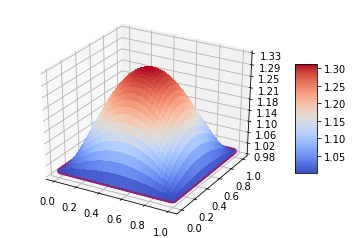

	#1: Objective = 2.230709445262668
	#2: Objective = 2.3597821472226985


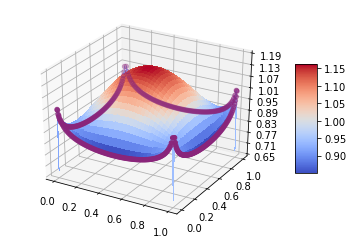

	#3: Objective = 2.058290658032793
	#4: Objective = 0.8948599161919236


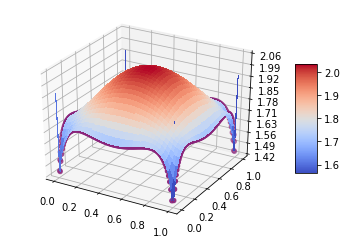

	#5: Objective = 0.3092087332268457
	#6: Objective = 0.19586492462031319


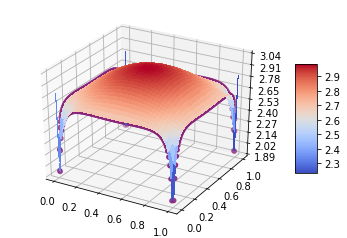

	#7: Objective = 0.1702331261276987
	#8: Objective = 0.16837414886450733


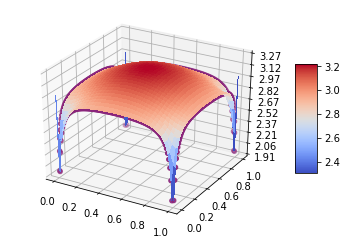

	#9: Objective = 0.16833769310289998


In [6]:
# Solve the problem
if p.debug:
    x, info = nlp.solve(problem.x0)
else:
    omp_threads = os.environ["OMP_NUM_THREADS"]
    
    times = []
    for i in range(repeats):
        print(f"i: {i +1}/{repeats}")
        start = time.time()
        x, info = nlp.solve(problem.x0)
        end = time.time()
        times.append(end - start)
        print(f"time: {times[-1]} s")
    
    file_exists = os.path.isfile(csv_name)
    with open(csv_name,'a') as csv:
        if not file_exists:
            csv.write("N, omp_threads, time_mean, time_var, repeats, obj_val, constraint_norm\n")
        line = f"{p.n}, {omp_threads}, {np.mean(times)}, {np.var(times)}, {repeats}, {info['obj_val']}, {np.linalg.norm(p.constraints(x))}\n"
        print(f"csv: {line}")
        csv.write(line)

# Analysis of the solution

Next, we can analyze the solution and visualize it

In [7]:
print("Constraints norm is (should be near 0)", np.linalg.norm(p.constraints(x)))

Constraints norm is (should be near 0) 0.0


In [8]:
# print("Solution of the primal variables: x=%s\n" % repr(x))
# print("Solution of the dual variables: lambda=%s\n" % repr(info['mult_g']))

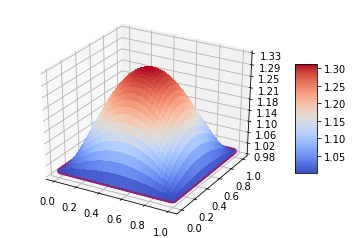

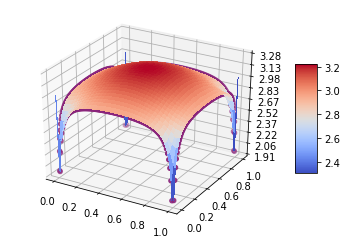

In [9]:
p.plot(x=p.x0)
# p.plot(y=p.y0)
p.plot()

In [10]:
data = pd.read_csv(csv_name, sep='\s*,\s*', engine='python')
data = data.sort_values(['N', 'omp_threads'])

# should be const for perfect weak scaling
data['time_per_cell'] = data['time_mean'] / data['N']**2

seqdata = data[data['omp_threads'] == 1][['N','time_mean']]
seqdata.rename(columns={'time_mean':'time_seq'}, inplace=True)
seqdata.head(20)

data = data.merge(seqdata, on='N')
data['su'] = data['time_seq'] / data['time_mean']
data['par_eff'] = data['su'] / data['omp_threads']
data.head(20)

N  omp_threads   time_mean  time_var  repeats   obj_val  \
0    50            1    0.242138       0.0        1  0.167732   
1    50           16    0.185258       0.0        1  0.167732   
2   250            1    7.693021       0.0        1  0.168363   
3   250           16    4.701869       0.0        1  0.168363   
4   500            1   51.825079       0.0        1  0.168262   
5   500           16   30.510311       0.0        1  0.168262   
6  1000            1  257.698395       0.0        1  0.168526   
7  1000           16  136.801044       0.0        1  0.168526   

   constraint_norm  time_per_cell    time_seq        su   par_eff  
0              0.0       0.000097    0.242138  1.000000  1.000000  
1              0.0       0.000074    0.242138  1.307027  0.081689  
2              0.0       0.000123    7.693021  1.000000  1.000000  
3              0.0       0.000075    7.693021  1.636162  0.102260  
4              0.0       0.000207   51.825079  1.000000  1.000000  
5              0.0       0.000122   51.825079  1.698609  0.106163  
6              0.0       0.000258  257.698395  1.000000  1.000000  
7              0.0       0.000137  257.698395  1.883746  0.117734

# Git

In [50]:
!git add main.ipynb

In [51]:
!git commit -m "data post processing"

[master cc6a588] Efficient hessian structure, fix jacobian structure nnz
 1 file changed, 1027 insertions(+), 924 deletions(-)
 rewrite 7/Jupyter/main.ipynb (92%)


In [52]:
!git push

Git 2.0 from 'matching' to 'simple'. To squelch this message
and maintain the current behavior after the default changes, use:

  git config --global push.default matching

To squelch this message and adopt the new behavior now, use:

  git config --global push.default simple

See 'git help config' and search for 'push.default' for further information.
(the 'simple' mode was introduced in Git 1.7.11. Use the similar mode
'current' instead of 'simple' if you sometimes use older versions of Git)

Counting objects: 9, done.
Delta compression using up to 8 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 89.91 KiB | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: 
remote: ========================================================================
remote: 
remote:       To receive notifications about scheduled maintenance, please
remote:    subscribe to the mailing-list gitlab-operations@sympa.ethz.ch. You
remote:        can subscribe to the mailing-l